Mark Evers<br>
mevers303@gmail.com<br>
https://githib.com/mevers303/missionmark

# MissionMark Document Sorting Proof of Concept
---

# Introduction
To sort the documents, we will be using a technique called Non-Negative Matrix Factorization (NMF).  NMF uses a term frequency/inverse document frequency (TF/IDF) matrix to discover "*latent topics*" within a corpus.  The number of latent topics to extract must be determined by the user.  I have created a couple of tools that will assist in choosing the number of topics to extract (not included in this demonstration, but you have seen them before).

What this process actually looks like is using a corpus to "train" a model to recognize a specified number of topics.  We will be using 42 topics in this demonstration.  Once we have a trained model, it can be used for two ultimate goals:
1. Determining how one or more documents relate to the latent topics.
2. Finding and listing documents that meet a certain criteria for topic relevancy.

There is a variety of ways to accomplish these two goals, with each way accomplishing it's own set of goals/criteria.

### About NMF
NMF uses an algorithm based in linear algebra to group the TF/IDF vectors.  The result is a model that relates each keyword to its relevancy in each topic that can be used to find the latent topics of any document in the corpus or any new documents it has never seen before.

### About Latent Topics
A latent topic is one that is not defined, but extracted based on how the TF/IDF keywords can be grouped in the training process.  The process is automatic and the only human input required is the *number* of topics to extract.  After they are created, these topics can be examined and labeled manually.
#### Advantages
 - The advantage to latent topics is that topics that the topics do not have to be known beforehand.  That would require us to read every single document in the corpus in order to manually pre-define every topic that may exist, which is exactly what we are trying to avoid.

#### Disadvantages
 - The topics are created purely by keyword; the meaning of each keyword is not taken into account.  This means that topics may be extracted based on keywords that are not relevant to our purpose, which is *types of work*.  In early tests, undesirable topics such as "US Army Corps of Engineers" were being found.  In the fbo_files database, documents that all contained the exact same, specific legal clause in the contract were being grouped even though the clause was not relevant to the type of work.<br><br>

 - **There is a simple solution!**<br>
   Well, two possible solutions:
  1. We can specify "stop words," which are words that are completely ignored in the entire process.  After extensive testing, I have found this to be the most effective solution.
  2. Another solution may be to only consider the "REQUIREMENTS" section of each document.  I did not find this to be effective, as a significant amount of relevent content was excluded from the more technical types of work (like *Computer Science*).
  
---

# Setup
#### Imports and definitions

In [1]:
import os, sys
sys.path.append(os.getcwd() + "/../src")

In [2]:
from pickle_workaround import pickle_load
from TfidfVectorizer import TfidfVectorizer
from vectorizer import tokenize, extract_requirements
from topics import search_models, plot_results
from data import get_query_corpus, get_connection

import numpy as np
import time
import datetime
import matplotlib.pyplot as plt

from sklearn.decomposition import NMF
from wordcloud import WordCloud

from jupyter_stuff import *

### TF/IDF
 - This section is more for technical intrigue, so you may want to skip to the 'How to use it' section to see what we can actually accomplish with this output.
 
A TF/IDF vector is generated for each document in the corpus.  TF/IDF is a technique used to weight the keywords of a document with relation to the corpus.  Each term is weighted inversely to its frequency within the corpus, meaning words that appear in a large number of documents (like 'contract') are not considered to be significant while words that appear in a small number of documents (like 'HVAC') are considered to be highly significant.

| | contract | hvac | engineering | ... |
| --- | --- | --- | --- | --- |
| **document 1** | 0.001 | 0.6 | 0 | ... |
| **document 2** | 0.001 | 0 | 0.75 | ... |
| **document 3** | 0.001 | 0.4 | 0.45 | ... |
| **...** | ... | ... | ... |  |

#### Load the corpus

In [3]:
_ = get_connection("/home/mark/Documents/missionmark/missionmark_db_creds")
query = """SELECT opportunity_id, program_description
           FROM import.govwin_opportunity
           WHERE program_description ILIKE('%REQUIREMENTS%')
        """
doc_ids, corpus = get_query_corpus(query, True)

tfidf = TfidfVectorizer(pickle_load("../output/CountVectorizer.pkl"), pickle_load("../output/TfidfTransformer.pkl"))
vocabulary = tfidf.get_feature_names()
print(len(vocabulary), "words")
print("Vectorizing documents...")
tfidf_corpus = tfidf.transform(corpus)
print(" -> Done!")

Connecting to Postgres database...
 -> Connection successful!
Loading corpus...
 -> 8851 documents loaded!
Loading ../output/CountVectorizer.pkl from cache...
 -> ../output/CountVectorizer.pkl loaded!
Loading ../output/TfidfTransformer.pkl from cache...
 -> ../output/TfidfTransformer.pkl loaded!
18494 words
Vectorizing documents...
 -> Done!                                                                       


---

# NMF Model
 - This section is more for technical intrigue, so you may want to skip to the 'How to use it' section to see what we can actually accomplish with this output.

The main usefulness of NMF comes in the form of two matrices.  The first is a matrix (H) of latent topics vs. key word strengths.  The second is a matrix (W) of documents vs. latent topic strengths.
#### The H matrix
The H matrix is pretty straightforward.  Each row represents a different latent topic and each column represents a keyword.  The contents of any individual cell contains the weight of a keyword within that topic.  It basically tells us which keywords are most important in identifying each topic.  One keyword may be relevant in identifying multiple different topics, or none at all.  What is most relevant for identifying a topic is the *set* of keywords it contains.

| | keyword_1 | keyword_2 | keyword_3 | ... |
| --- | --- | --- | --- | --- |
| **topic 1** | 0 | 0.5 | 0 | ... |
| **topic 2** | .75 | 0.1 | 0 | ... |
| **topic 3** | 0.2 | 0 | 0.8 | ... |
| **...** | ... | ... | ... |  |

#### The W matrix
The W matrix is what relates each individual document to the topics.  Each row represents one document, and each column is that document's strength in each topic.  A document commonly relates to multiple topics on varying degrees, but we usually only want to pick the strongest ones.  A new W matrix can quickly be generated for new documents/corpora in the future.  This ability is what will useful as more documents are added to the database.

| | topic 1 | topic 2 | topic 3 | ... |
| --- | --- | --- | --- | --- |
| **document 1** | 0 | 0.6 | 0 | ... |
| **document 2** | 0.1 | 0.1 | 0.55 | ... |
| **document 3** | 0.3 | 0.4 | 0 | ... |
| **...** | ... | ... | ... |  |

## Generate a model with 42 topics on the entire corpus
This produces a first level of 42  more general latent topics.  Some of these topics may be specific enough for our purposes, and some may not.  If we find a certain topic to be too general, we can build a second (or even more) level of sub-topics.  This will be covered later.

In [4]:
nmf = pickle_load("../output/NMF.pkl")

H = nmf.components_
H_normalized = H / H.max(axis=1).reshape((-1, 1))
W = nmf.transform(tfidf_corpus)
W_normalized = W / W.max(axis=0)

print("Found", H.shape[0], "topics")

Loading ../output/NMF.pkl from cache...
 -> ../output/NMF.pkl loaded!
Found 42 topics


---

# How to use it
Using these two innocuous matrices, a little human intuition, and a lot of linear algebra we can acheive a wide range of goals.  We will focus on a couple of different ways to identify new documents/contracts that a MissionMark customer may be interested in.  We will explore four ways to use this model:
1. **Searching using a desirable document as the search criteria**
 - Find all the topics relevant to this document
 - List other documents with a similar combination of topic relevancies.<br><br>
2. **Searching by keyword**
 - Find all topics where the keyword is relevant
 - List other documents within those topics.<br><br>
3. **Breaking down a large, broad topic into sub-topics**<br><br>
4. **Finding the topics within an SQL query**

<br>
These 4 techniques can be used in tandem, stacked on top of one another, and in any order you can imagine!  These examples are merely a demonstration of one way each technique can be used.

**!!! Bear in mind that the percentages displayed from here on out are more for debugging purposes to be interpreted by a data scientist and do not necessarily represent an absolute strength, probability, certainty, confidence level, or anything like that. !!!**

# 1) Searching using a desirable document as the search criteria
One use for NMF is the ability use a known desirable document to search for other documents that are highly similar to it.

Here we will use a random document to find other documents that are related to it.  Using this technique, we can identify documents that have similar strengths to the original in each of the 42 topics.  This way we can find other topics that relate to the same unique combination of topics as the one we already know is desirable.  This is in contrast to searching based on relevancy to only a single topic, as demonstrated above.

#### Examine the document we know to be desirable (document #500)

In [5]:
def top7_to_file(topic_i, _W, _corpus, _doc_ids, _tfidf, _nmf, n_sentences=2, path="../static/wordclouds/"):

    with open(path + str(topic_i) + "_summaries.txt", "w") as f:

        f.write(f"TOP 7 MOST RELEVANT DOCUMENTS FOR TOPIC {topic_i} (auto-summarized to {n_sentences} sentences)\n")
        f.write(f"These are the {n_sentences} from each document most relevant to topic {topic_i}.\n\n")

        i = 0
        for doc, strength in get_top_10_docs(_W, topic_i):
            if i == 7:
                break
            f.write("*************************************************************\n")
            f.write(f"ID: {_doc_ids[doc]} -> STRENGTH: {round(strength * 100, 2)}%\n\n")
            f.write(summarize_doc_nmf(_corpus[doc], _tfidf, _nmf, topic_i, n_sentences=n_sentences))
            f.write("\n\n")
            i += 1

for topic_i in range(42):
    top7_to_file(topic_i, W_normalized, corpus, doc_ids, tfidf, nmf)

In [6]:
doc_i = 500

doc = corpus[doc_i]
doc_topics = W_normalized[doc_i]
print("Relevant topics:")
[print(str(i).rjust(2), " = ", round(x * 100, 2), "%", sep="") for i, x in sorted(enumerate(doc_topics), key=lambda item: item[1], reverse=True) if x]
print("\nFULL TEXT:")
print(doc)

Relevant topics:
27 = 38.01%
20 = 25.99%
34 = 25.65%
31 = 24.07%
 3 = 18.78%
 2 = 11.4%
 5 = 4.75%
24 = 4.52%
18 = 4.43%
14 = 3.35%
23 = 2.72%
 8 = 2.58%
19 = 1.93%
30 = 1.75%
13 = 1.48%
16 = 0.61%

FULL TEXT:
The Department of Army, Army Installation Management Command (IMCOM, may have a continuing requirement for scientific, engineering and technical expertise in support of the Environmental and Natural Resources Division (ENRD) and Engineering Plans and Services Division (EPSD) missions of the Directorate of Public Works at Fort Huachuca, Arizona.
PREVIOUS REQUIREMENTS:
Scientific, engineering and technical expertise in support of the Environmental and Natural Resources Division (ENRD) and Engineering Plans and Services Division EPSD) missions of the Directorate of Public Works at Fort Huachuca, Arizona
Tasks will generally fall within the areas of:
Analyses, studies, evaluation, and/or remediation of the effects of Fort Huachuca activities
Preparation of designs, reports, plans, an

### That's a lot of topics!
This document calls for "engineering and techical expertise in support of the Environmental and Natural Resources Division."  So maybe a MissionMark customer has expressed interest in this specific document, and would like to see other engineering contracts relating to environmental projects.

#### First let's look at the wordclouds of the topics that are most relevant to this document (29, 34, 16, 3, 40)

Topic 27


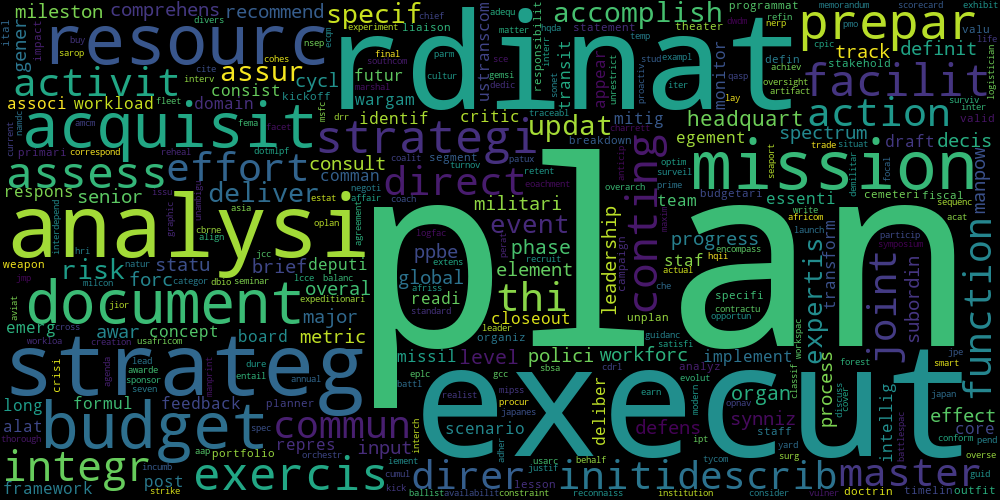


Topic 20


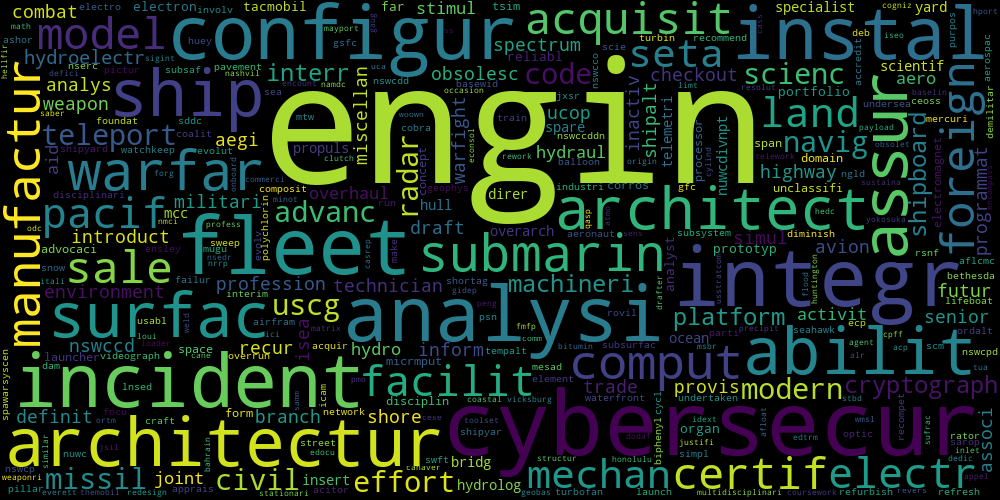


Topic 34


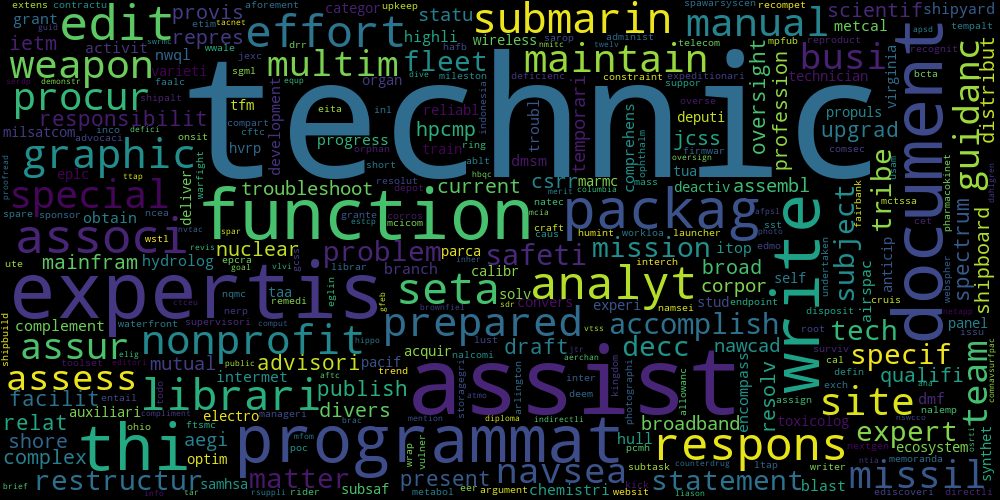


Topic 31


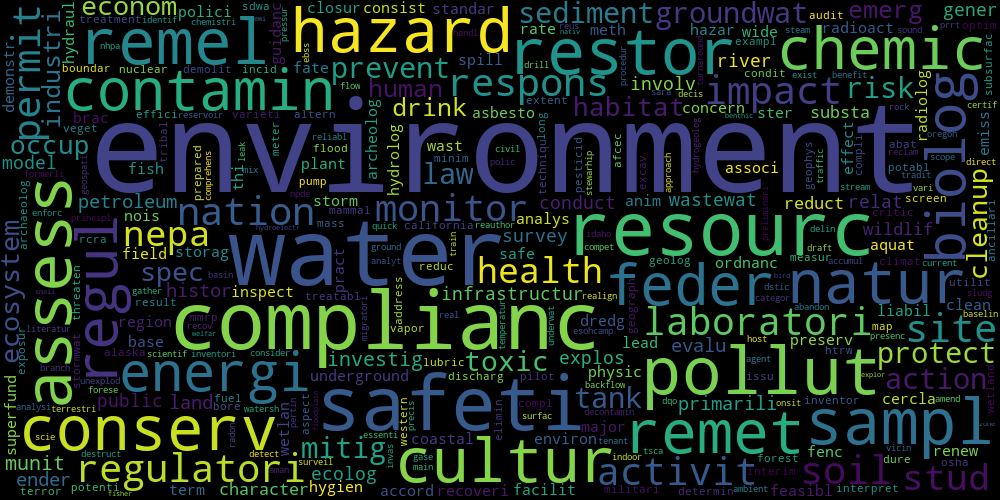


Topic 3


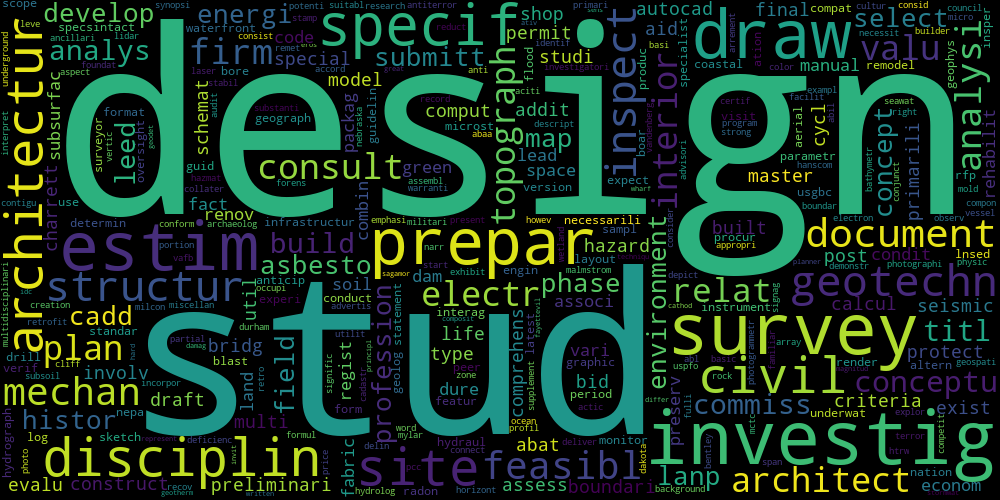

In [10]:
good_topics = [27, 20, 34, 31, 3]
for topic_i in good_topics:
    print("Topic", topic_i)
    display(Image(filename=f"../static/wordclouds/{topic_i}_nmf_wordcloud.png"))
    print()

Now that we have an idea of the type of documents we are looking for, let's look for other documents that relate strongly to the unique set of topics in document 500.

#### Find top 5 documents relevant to this one

In [8]:
from scipy.spatial.distance import cosine
distances = [cosine(W[doc_i], W[i]) for i in range(W.shape[0])]
best_matches = np.argsort(distances)[1:6]

print("DOCUMENTS MOST RELEVANT TO DOCUMENT #500\n")
for i in best_matches:
    print("*************************************")
    print(corpus[i])
    print()

DOCUMENTS MOST RELEVANT TO DOCUMENT #500

*************************************
The Department of the Army, U.S. Army Corps of Engineers (USACE), Honolulu District, has a requirement for Engineering and Environmental Planning services for miscellaneous projects primarily located within the State of Hawaii, but may include projects outside the state within the Pacific Ocean Division (POD) area and ad hoc projects located in other parts of Asia.
REQUIREMENTS:
Architect-Engineer services procured in accordance with PL 92-582 (Brooks A-E Act) and FAR Part 36, are required for various military and civil works projects primarily located within the State of Hawaii, but may include projects outside the state within the Pacific Ocean Division (POD) area and ad hoc projects located in other parts of Asia
No award of task orders for work outside of the Honolulu Engineer District will be undertaken without authorization from the affected District within POD
Work includes A-E services for comprehen

#### There they are!
For this demonstration we just picked the top 5.  We can also set a similarity threshold and find every document that meets the criteria as well (not demonstrated here).

---

## 2) Searching by keyword
We also are able to search the H matrix for one or more topics that are relevant to a specific keyword.  From there, we can identify all the documents relevant to those topics.  In the demonstration that follows, we will demonstrate this ability with the keyword "HVAC".  Once we know the relevant topics, we can then identify other documents that rank highly within those topics

#### Find topics where "hvac" is significant
Here I have created a function that finds all the topics where the weight for the term "HVAC" is not zero.  It only matters that we pick the ones with the higher percentages relative to the others in the list, so do not be discouraged that the highest is only displayed as 56.96%.

In [15]:
term_search("hardwar", H_normalized, tfidf)

16 = 45.54%
24 = 4.19%
25 = 3.95%
33 = 2.71%
35 = 1.75%
26 = 0.56%
39 = 0.08%


We can see that the term "hvac" is most relevant in topics 13 and 31 by a significant amount, and topic 19 to a lesser degree.

### Explore topics
Let's explore the wordclouds and top 7 documents for each of these three topics.  I have created an auto-summarization function that displays only the two most significant sentences in terms of their respective topics.  **This is how any given latent topic can be manually labeled.**

#### Topic 30: General Construction, Repair, and Renovation
By examining the output found below, we can label this topic as "General Construction, Repair, and Renovation."  This topic is about general construction-heavy maintenance.  Recall that "HVAC" was the most related to this topic with a value of 57.931%.

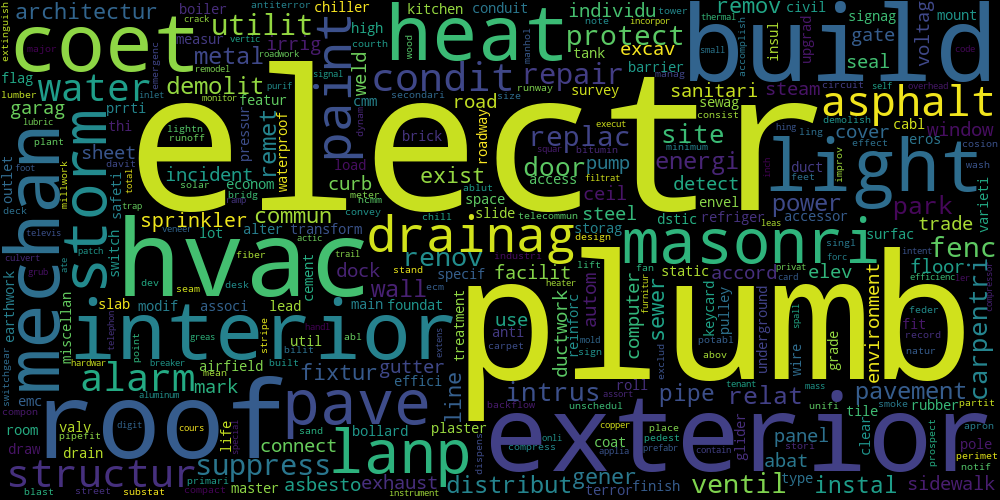

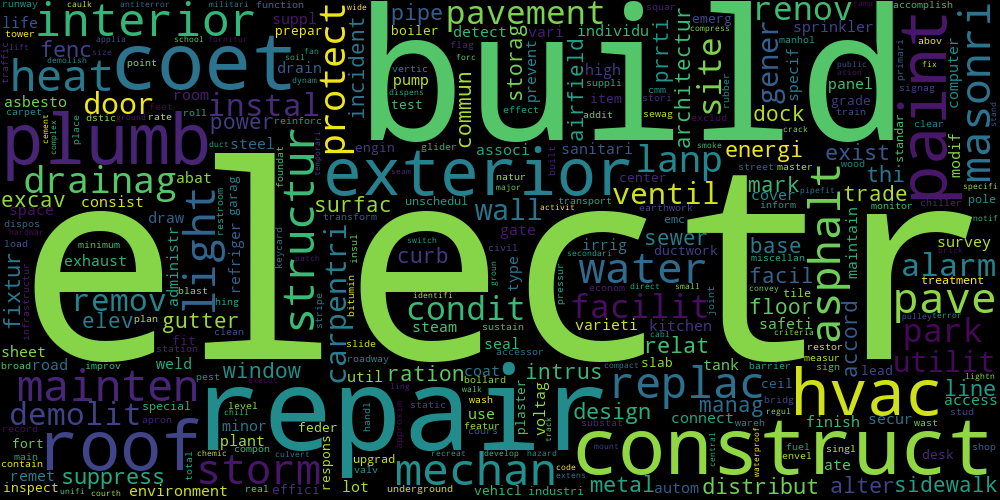

TOP 7 MOST RELEVANT DOCUMENTS FOR TOPIC 33 (auto-summarized to 2 sentences)
These are the 2 from each document most relevant to topic 33.

*************************************************************
ID: 129454 -> STRENGTH: 100.0%
The Department of the Army, National Guard Bureau (NGB), may have a continuing requirement for construction services in the state of Mississippi

PREVIOUS REQUIREMENTS:
Typical work includes, but is not limited to:
Interior and exterior renovations
Heating and air-conditioning
HVAC controls
Plumbing
Fire suppression
Interior and exterior electrical and lighting
Fire and intrusion alarms
Communications
Limited utilities
Site-work
Landscaping
Fencing
Masonry,
Roofing
Concrete
Asphalt paving
Storm drainage
Limited environmental remediation
Construction of new facilities
Surveys
Studies
Design-build
Other related work

*************************************************************
ID: 124026 -> STRENGTH: 98.5%
The Department of the Army, National Guard Bureau (NG

In [11]:
topic_i = 33
top7(topic_i, W_normalized, corpus, doc_ids, tfidf, nmf)

#### Topic 13: Building Mechanical Systems Maintenance
By looking at the output below, we can label this topic as "Building Mechanical Systems Maintenance."  Recall that "HVAC" was the second most related to this topic with a value of 41.62%.

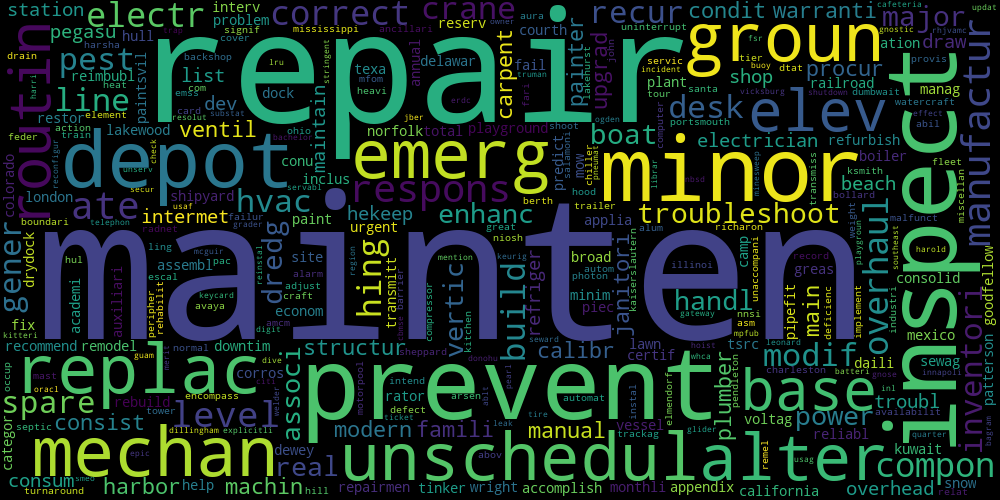

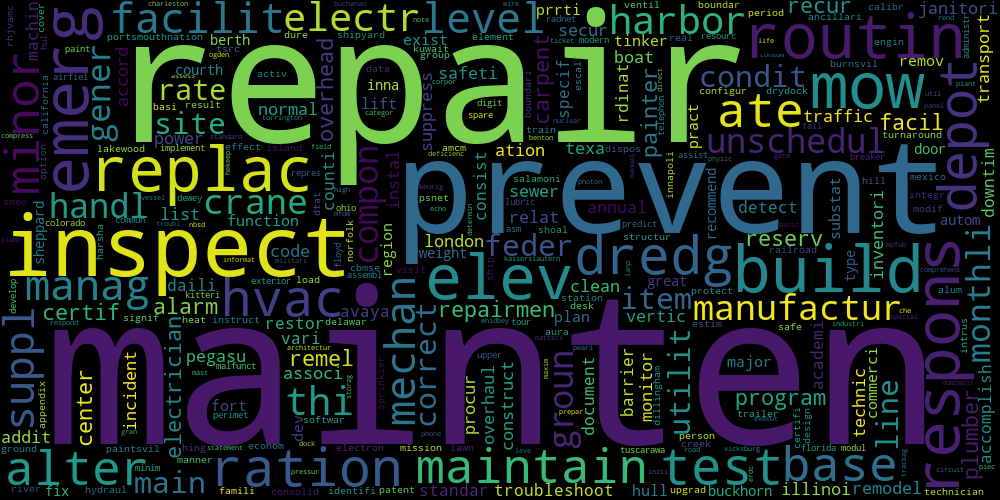

TOP 7 MOST RELEVANT DOCUMENTS FOR TOPIC 4 (auto-summarized to 2 sentences)
These are the 2 from each document most relevant to topic 4.

*************************************************************
ID: 133817 -> STRENGTH: 100.0%
The Department of Defense (DoD), Washington Headquarters Services (WHS), has a requirement for Preventive and Corrective Repair Maintenance services at Pentagon Reservation, Washington D.C

REQUIREMENTS:
The Contractor shall:
Provide a comprehensive maintenance program for Mechanical equipment and systems
Furnish all parts, labor, materials, and supervision necessary for the preventive maintenance, predictive maintenance, any corrective maintenance repairs, service calls and major and minor IDIQ repairs for the equipment

*************************************************************
ID: 149531 -> STRENGTH: 85.42%
REQUIREMENTS                                                                    
USACE is seeking Facilities Support Services with current and releva

In [12]:
topic_i = 4
top7(topic_i, W_normalized, corpus, doc_ids, tfidf, nmf)

#### Topic 19:  General Building Maintenance
By looking at the output below, we can label this topic as "General Building Maintenance."  "HVAC" came up as related to this topic, but to a much lesser degree than topics 13 and 31.  This means that HVAC is relevant to this topic, but it is not highly specific to "General Building Maintenance."  This topic is more about lighter handyman type maintenance.  Recall that "HVAC" was the the least related to this topic with a value of 5.03%.

In [ ]:
topic_i = 19
top7(topic_i, W_normalized, corpus, doc_ids, tfidf, nmf)

___

### Find other documents in Building Mechanical Systems Maintenance (#30)
Now that we know the topics most relevant to the term "HVAC", let's pick Building Mechanical Systems Maintenance and find all the other documents within this topic.

#### Pick a threshold to only chose the most relevant documents
As we covered before, any one topic will most likely be related to multiple topics on varying levels.  Some documents that happen to contain a couple of the other minorly relevant keywords for topic 13, but the document will not actually be about Building Mechanical Systems Maintenance.  We can eliminate these undesired documents from the list by specifying a relevancy threshold.

To help choose a threshold, we can look at the distribution of all the relevancy values.

In [ ]:
topic30 = W[:, 30]
topic30_normalized = topic30 / topic30.max(axis=0)
_ = plt.hist(topic30_normalized[topic30_normalized > 0.0], bins=50)

We usually want to choose the "elbow" of the graph, so in this case we will set the threshold to 0.08.  If we find that relevent documents are being excluded or irrelevent documents are being included, we can adjust the threshold up or down.

In [ ]:
threshold = .06

topic30_i = topic30_normalized > threshold
topic30_tfidf = tfidf_corpus[topic30_i]
# topic30_corpus = corpus[topic30_i]
# topic30_doc_ids = doc_ids[topic30_i]

print(topic30_tfidf.shape[0], "documents relating to Building Mechanical Systems Maintenance.")

#### We found 351 documents within topic 30!

---

# 3) Breaking down a broad topic into sub-topics
When creating latent topics from across the entire database, we may find that some of the "general topics" or first-level topics are too broad.

### Computer Science (Topic #5)
The *Computer Science* topic seems to encompass a range of projects in specialized areas.  We can further group this broad topic into more specific sets of sub-topics.

Let's take a look at of what we're working with:

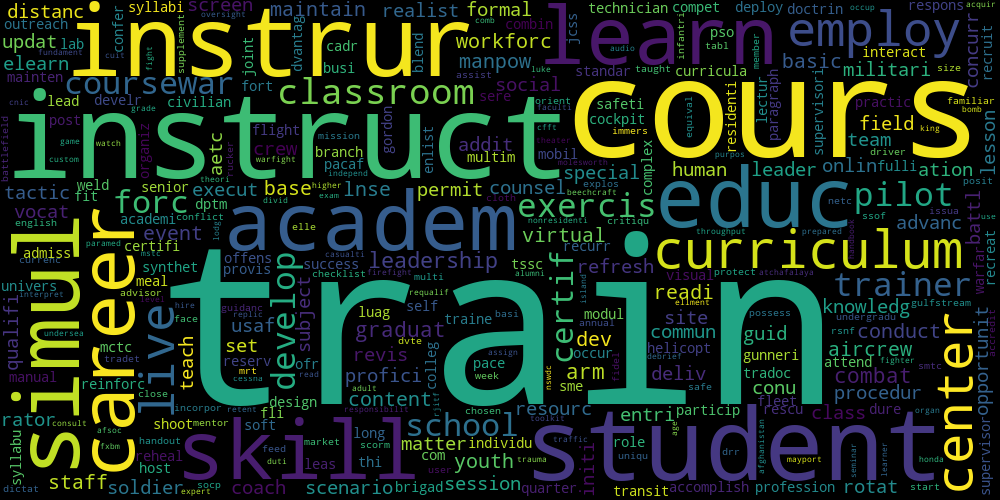

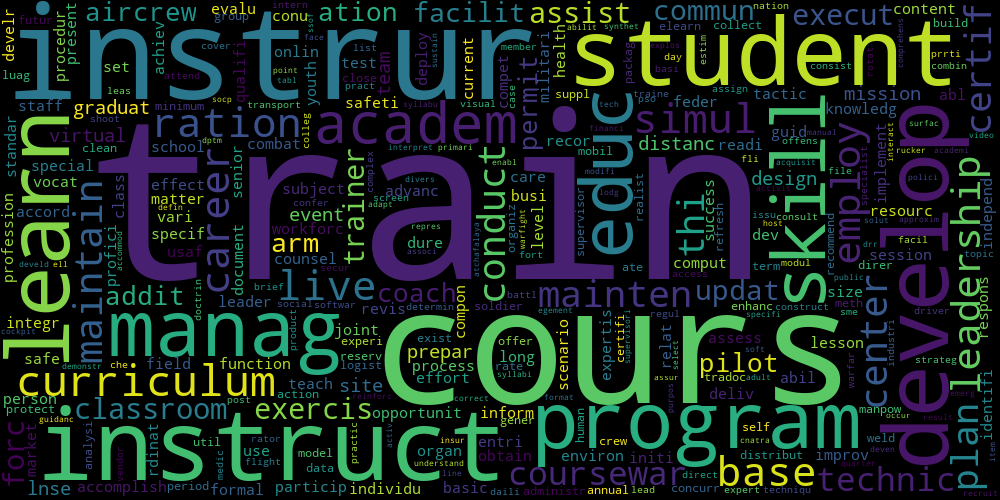

TOP 7 MOST RELEVANT DOCUMENTS FOR TOPIC 15 (auto-summarized to 2 sentences)
These are the 2 from each document most relevant to topic 15.

*************************************************************
ID: 138355 -> STRENGTH: 100.0%
The United States Marine Corps, Marine Corps Systems Command has a continuing requirement for Range Training Systems

PREVIOUS REQUIREMENTS:
The Contractor shall perform a mix of:
Systems and logistics engineering
Design
Development
Systems integration
Training and installation of the RTS

*************************************************************
ID: 165419 -> STRENGTH: 84.54%
The Department of the Air Force, Air Education and Training Command (AETC), 2nd Air Force, 81st Training Wing (81 TW), 81st Training Group (81 TRG), 333rd Training Squadron may have a continuing requirement for cyber operations training support services

PREVIOUS REQUIREMENTS
Cyber operations training support services

*************************************************************
I

In [16]:
topic_i = 15
top7(topic_i, W_normalized, corpus, doc_ids, tfidf, nmf)

#### It's clearly about Computer Science, but there are a lot of specialty areas within the topic
These documents all clearly outline contracts revolving around hardware, software, and digital technology in a broad sense.  We can also see that these documents cover a wide range of specialized fields within computer science.  Let's break this general topic down into more specific sub-topics:

#### Pick a threshold and find the relevant documents

In [ ]:
topic33 = W[:, 33]
topic33_normalized = topic33 / topic33.max(axis=0)
_ = plt.hist(topic33_normalized[topic33_normalized > 0.0], bins=50)

In [ ]:
threshold = .2

topic33_i = topic33_normalized > threshold
topic33_tfidf = tfidf_corpus[topic33_i]
topic33_corpus = corpus[topic33_i]
topic33_doc_ids = doc_ids[topic33_i]

print(topic33_tfidf.shape[0], "documents relating to Computer Science.")

#### Create a new topic model with 7 latent topics from the Computer Science corpus

In [ ]:
n_topics = 7
topic33_nmf = NMF(n_components=n_topics, max_iter=666, random_state=666)

topic33_W = topic33_nmf.fit_transform(topic33_tfidf)
topic33_W_normalized = topic33_W / topic33_W.max(axis=0)
topic33_H = topic33_nmf.components_
topic33_H_normalized = topic33_H / topic33_H.max(axis=1).reshape((-1, 1))

print(topic33_nmf.n_iter_, "iterations")

#### Explore the newly created latent topics

In [ ]:
for topic_i in range(n_topics):
    print("*************************************************************************************\n*************************************************************************************")
    print("Latent Sub-Topic", topic_i)
    wc = WordCloud(background_color="black", max_words=333, width=1000, height=500)
    wc.fit_words({vocabulary[word_i]: topic33_H[topic_i, word_i] for word_i in range(topic33_H.shape[1]) if topic33_H[topic_i, word_i]})
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    top7(topic_i, topic33_W_normalized, topic33_corpus, topic33_doc_ids, tfidf, topic33_nmf, False, 3)

### We now have a new topic model (of sub-topic) with H and W matrices that we can use to employ every technique covered in this report!
I will let you explore the results yourself (above).

We can use the exact same techniques already covered and every technique that follows to search for documents and/or topics with this new model.
 - Searching by keyword
 - Using a specific document as a search criteria

---

# 4) Finding the topics within an SQL query
Instead of creating sub-topics from one of the latent topics created by an NMF model, we can do the same thing limited to a specific SQL query.

#### Select all documents containing the term '%engineer%'

In [ ]:
query = """SELECT opportunity_id, program_description
           FROM import.govwin_opportunity
           WHERE program_description ILIKE('%engineer%')
        """
engineer_doc_ids, engineer_corpus = get_query_corpus(query, True)

print("Vectorizing documents...")
engineer_tfidf = tfidf.transform(engineer_corpus)
print(" -> Done!")

#### Create a new topic model with 12 latent topics from the 'engineer' corpus

In [ ]:
n_topics = 12
engineer_nmf = NMF(n_components=n_topics, max_iter=666, random_state=666)

engineer_W = engineer_nmf.fit_transform(engineer_tfidf)
engineer_W_normalized = engineer_W / engineer_W.max(axis=0)
engineer_H = engineer_nmf.components_
engineer_H_normalized = engineer_H / engineer_H.max(axis=1).reshape((-1, 1))

print(engineer_nmf.n_iter_, "iterations")

#### Explore the newly created latent topics

In [ ]:
for topic_i in range(n_topics):
    print("*************************************************************************************\n*************************************************************************************")
    wc = WordCloud(background_color="black", max_words=333, width=1000, height=500)
    wc.fit_words({vocabulary[word_i]: engineer_H[topic_i, word_i] for word_i in range(engineer_H.shape[1]) if engineer_H[topic_i, word_i]})
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    top7(topic_i, engineer_W_normalized, engineer_corpus, engineer_doc_ids, tfidf, engineer_nmf, False, 2)

### We now have a new topic model (of sub-topics within the SQL '%engineer%' query) with H and W matrices that we can use to employ every technique covered in this report!
I will let you explore the results (above) yourself.

We can use the exact same techniques already covered and every technique that follows to search for documents and/or topics with this new model.
 - Searching by keyword
 - Using a specific document as a search criteria

---

# Summary
We can use NMF in various ways to achieve three main purposes:
1. Discovering a number of latent topics within a corpus.
2. Finding how a document or set of documents relates to the latent topics discovered.
3. Finding and listing documents that meet a certain criteria.

Using this information, we can use a variety of techniques to label documents and/or search for other related documents.  You can apply what you've seen here to any other combination of scenarios.  This demonstration was meant to show you the capabilities so you can imagine how it can be applied to other situations.  There are even more possibilities than those covered here.

I would like to learn more about MissionMark's process in assisting its customers to indentify other tasks that this can be used for.  I bet there are some areas where this NMF technique will be of use that you are not aware of and therefore do not know to ask for!